# **Data Mining for Confidence Level Detection**

Lydia Lonzarich and Katie Park
CPSC 322-01, Fall 2025

# Import Libraries

In [13]:
import importlib

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyRandomForestClassifier, MyDecisionTreeClassifier, MyNaiveBayesClassifier, MyDecisionTreeSolo


import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

# Load the Confidence Level Dataset

In [14]:
confidence_raw_data = MyPyTable().load_from_file("confidence_features.csv") # the unnormalized dataset.
confidence = confidence_raw_data.new_deep_copy() # the dataset we will normalize. This is so the original dataset retains its true values without being normalized

all_attributes = ["body_lean_x", "shoulder_center_x", "hip_center_x", "spine_angle", "head_tilt_angle", "shoulder_slope", "head_direction", "arm_position", "posture"]
continuous_attributes = all_attributes[:6]
categorical_attributes = all_attributes[6:]



<function matplotlib.pyplot.show(close=None, block=None)>

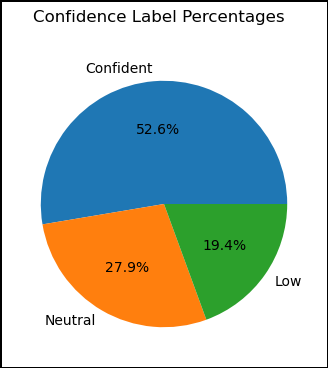

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (4, 4))

freq = myutils.get_frequency(confidence_raw_data.get_column("confidence_label"))

xs = []
ys = []

for key in freq:
    xs.append(key)
    ys.append(freq[key])

plt.pie(ys, labels = xs, autopct = "%1.1f%%")
fig = plt.gcf()
fig.suptitle("Confidence Label Percentages")
fig.patch.set_edgecolor("black")
fig.patch.set_linewidth(1)
plt.show

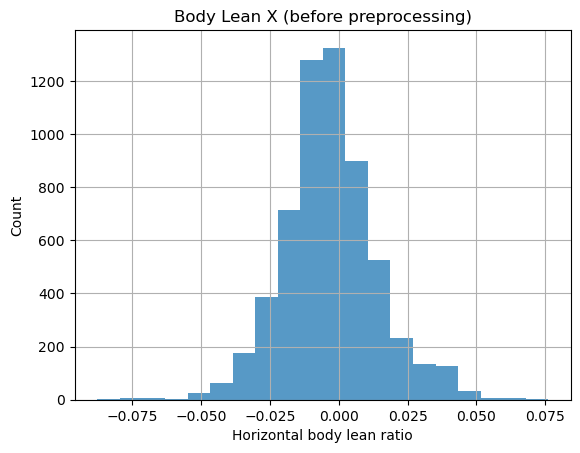

In [4]:
plt.figure()

x = confidence_raw_data.get_column("body_lean_x")

plt.hist(x, bins = 20, alpha = 0.75)
plt.grid(True)
plt.title("Body Lean X (before preprocessing)")
plt.xlabel("Horizontal body lean ratio")
plt.ylabel("Count")
plt.show()




In [5]:
# normalize cols that have type=float attribute values.
confidence.normalize_columns(continuous_attributes)

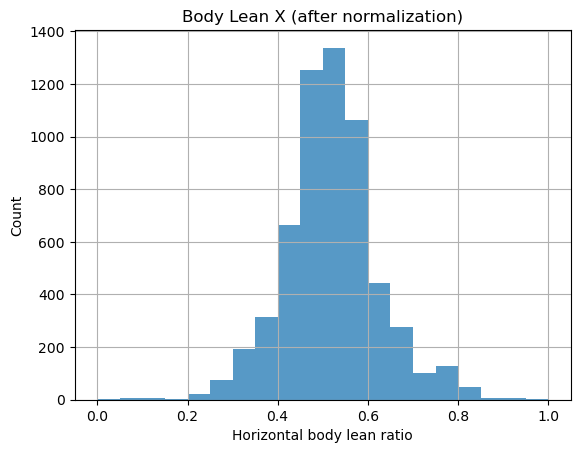

In [6]:
plt.figure()

x = confidence.get_column("body_lean_x")

plt.hist(x, bins = 20, alpha = 0.75)
plt.grid(True)
plt.title("Body Lean X (after normalization)")
plt.xlabel("Horizontal body lean ratio")
plt.ylabel("Count")
plt.show()

In [7]:


# find the column indices of the attributes we're using
att_indices = []
for att in all_attributes:
   att_idx = confidence.column_names.index(att)
   att_indices.append(att_idx)

# discretize values (to make continuous attribute vals --> categorical attribute vals)
for row_index, row in enumerate(confidence.data):
    for val_index, value in enumerate(row):
        if val_index in att_indices and type(confidence.data[row_index][val_index]) != str:
            confidence.data[row_index][val_index] = myutils.my_discretizer(confidence.data[row_index][val_index])

confidence.compute_summary_statistics(continuous_attributes).pretty_print()




attribute            min    max    mid      avg    median
-----------------  -----  -----  -----  -------  --------
body_lean_x            1     10    5.5  5.20071         5
shoulder_center_x      1     10    5.5  5.42663         5
hip_center_x           1     10    5.5  5.45066         5
spine_angle            1     10    5.5  5.50042         5
head_tilt_angle        1     10    5.5  5.15902         5
shoulder_slope         1     10    5.5  2.11615         1


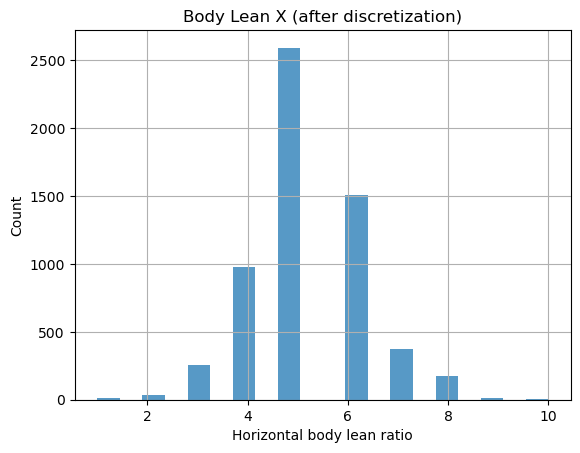

In [8]:
plt.figure()

x = confidence.get_column("body_lean_x")

plt.hist(x, bins = 20, alpha = 0.75)
plt.grid(True)
plt.title("Body Lean X (after discretization)")
plt.xlabel("Horizontal body lean ratio")
plt.ylabel("Count")
plt.show()

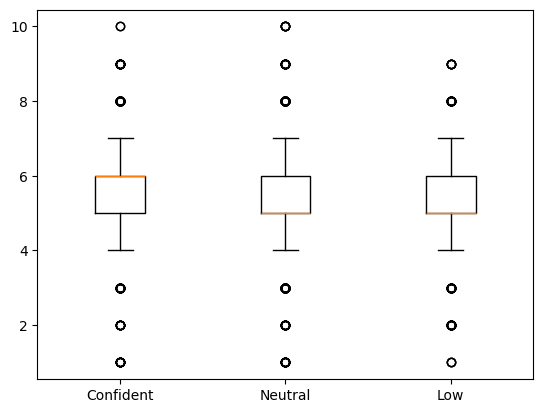

In [9]:
plt.figure()

data = confidence.get_column_rows(["hip_center_x", "confidence_label"])

x1 = []
x2 = []
x3 = []

for row in data:
    if row[1] == "Confident": x1.append(row[0])
    elif row[1] == "Neutral": x2.append(row[0])
    elif row[1] == "Low": x3.append(row[0])

plt.boxplot([x1, x2, x3])
plt.xticks([1, 2, 3], ["Confident", "Neutral", "Low"])
plt.show()

Text(0.5, 1.0, 'Shoulder Slope vs Confidence Label')

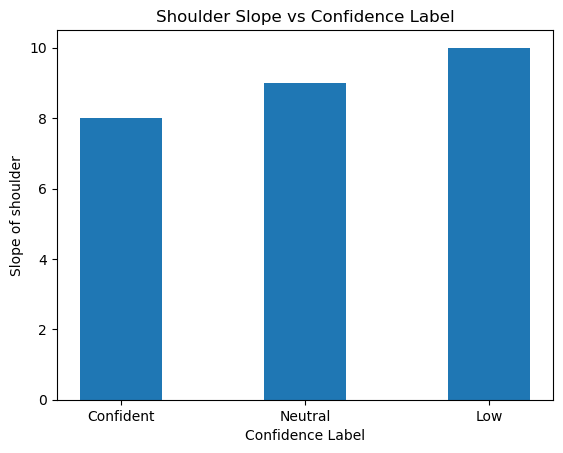

In [10]:
plt.figure()

x = confidence.get_column("confidence_label")
y = confidence.get_column("body_lean_x")

plt.bar(x, y, 0.45, align="center")
plt.xlabel("Confidence Label")
plt.ylabel("Slope of shoulder")
plt.title("Shoulder Slope vs Confidence Label")

In [11]:
print(myutils.get_frequency(confidence.get_column("posture")))


{'Upright': 3521, 'Stiff': 2045, 'Slouched': 383}


# Implement Random Forest for Classification

In [12]:
# define X and y data
X = [[row[idx] for idx in att_indices] for row in confidence.data]
y = confidence.get_column("confidence_label")

# create a random forest classifer instance using the best N, M, and F parameters found.
myForest = MyRandomForestClassifier(N=20, M=5, F=4)

# train the random forest classifier on our train data. (class does internal split into train and test set, so here we just use internal train set).
myForest.fit(X, y)

# generate confidence label predictions using our random forest classifier. (uses internal test set).
y_preds = myForest.predict()

# display accuracy of random forest classifier.



TypeError: 'NoneType' object is not iterable

In [ ]:
print("----- PERFORMANCE METRICS -----")
print(f"Accuracy Score: {round(myevaluation.accuracy_score(myForest.y_test, y_preds), 2)}")
print(f"Error Rate: {round(1 - myevaluation.accuracy_score(myForest.y_test, y_preds), 2)}")
print(f"Precision Score: {round(1 - myevaluation.multiclass_precision_score(myForest.y_test, y_preds, ["Confident", "Neutral", "Low"]), 2)}")
print(f"Recall Score: {round(1 - myevaluation.multiclass_recall_score(myForest.y_test, y_preds, ["Confident", "Neutral", "Low"]), 2)}")
print(f"F1 Score: {round(1 - myevaluation.multiclass_f1_score(myForest.y_test, y_preds, ["Confident", "Neutral", "Low"]), 2)}")

----- PERFORMANCE METRICS -----
Accuracy Score: 0.54
Error Rate: 0.46
Precision Score: 0.62
Recall Score: 0.46
F1 Score: 0.56


In [ ]:
# # define X_train and y_train datasets
# X = [[row[idx] for idx in att_indices] for row in confidence.data]
# y = confidence.get_column("confidence_label")



# # compute k fold cross validation with k=10 folds to evaluate model performance with different N, M, and F...
# # attempt 1: N=20, M=5, F=4
# acc, err_rate, precision, recall, f1, y_trues, y_preds = myutils.cross_val_predict(X, y, 10, lambda: MyRandomForestClassifier(N = 20, M = 5, F = 4), True)
# print("Performance metrics for M=20, M=5, F=4...")
# print("accuracy: ", acc, ", error rate: ", err_rate, ", precision: ", precision, ", recall: ", recall, ", f1: ", f1)

# # attempt 2: N=20, M=7, F=2
# acc, err_rate, precision, recall, f1, y_trues, y_preds = myutils.cross_val_predict(X, y, 10, lambda: MyRandomForestClassifier(N = 20, M = 7, F = 2), True)
# print("Performance metrics for M=20, M=7, F=2...")
# print("accuracy: ", acc, ", error rate: ", err_rate, ", precision: ", precision, ", recall: ", recall, ", f1: ", f1)




# # create a random forest classifer instance using the best N, M, and F parameters found.
# myForest = MyRandomForestClassifier(N = 20, M = 5, F = 4)

# # train the random forest classifier on our train data.
# myForest.fit(myForest.X_train, myForest.y_train)

# # generate confidence label predictions using our random forest classifier.
# y_preds = myForest.predict()

# # display accuracy of random forest classifier.
# print(myevaluation.accuracy_score(myForest.y_test, y_preds))



In [ ]:
X = confidence.get_column_rows(all_attributes)
y = confidence.get_column("confidence_label")

# attempt 1: N = 10, M = 5, F = 10
myForest = MyRandomForestClassifier(N = 10, M = 5, F = 10)
myForest.fit(X, y, test_size=0.33)
y_pred = myForest.predict()
y_true = myForest.y_test

print("attempt 1: N = 10, M = 5, F = 10")
acc = myevaluation.accuracy_score(y_true, y_pred)
precision = myevaluation.multiclass_precision_score(y_true, y_pred)
recall = myevaluation.multiclass_recall_score(y_true, y_pred)
f1 = myevaluation.multiclass_f1_score(y_true, y_pred)


print("accuracy: ", acc, ", error rate: ", round(1 - acc, 2), ", precision: ", precision, ", recall: ", recall, ", f1: ", f1)

# attempt 2: N = 20, M = 5, F = 10
myForest = MyRandomForestClassifier(N = 20, M = 5, F = 10)
myForest.fit(X, y, test_size=0.33)
y_pred = myForest.predict()
y_true = myForest.y_test


print("attempt 2: N = 20, M = 5, F = 10")
acc = myevaluation.accuracy_score(y_true, y_pred)
precision = myevaluation.multiclass_precision_score(y_true, y_pred)
recall = myevaluation.multiclass_recall_score(y_true, y_pred)
f1 = myevaluation.multiclass_f1_score(y_true, y_pred)


print("accuracy: ", acc, ", error rate: ", round(1 - acc, 2), ", precision: ", precision, ", recall: ", recall, ", f1: ", f1)


# attempt 3: N = 30, M = 5, F = 10
myForest = MyRandomForestClassifier(N = 30, M = 5, F = 10)
myForest.fit(X, y, test_size=0.33)
y_pred = myForest.predict()
y_true = myForest.y_test


print("attempt 3: N = 30, M = 5, F = 10")
acc = myevaluation.accuracy_score(y_true, y_pred)
precision = myevaluation.multiclass_precision_score(y_true, y_pred)
recall = myevaluation.multiclass_recall_score(y_true, y_pred)
f1 = myevaluation.multiclass_f1_score(y_true, y_pred)


print("accuracy: ", acc, ", error rate: ", round(1 - acc, 2), ", precision: ", precision, ", recall: ", recall, ", f1: ", f1)



# attempt 4: N = 5, M = 5, F = 10
myForest = MyRandomForestClassifier(N = 5, M = 5, F = 10)
myForest.fit(X, y, test_size=0.33)
y_pred = myForest.predict()
y_true = myForest.y_test


print("4: N = 5, M = 5, F = 10")
acc = myevaluation.accuracy_score(y_true, y_pred)
precision = myevaluation.multiclass_precision_score(y_true, y_pred)
recall = myevaluation.multiclass_recall_score(y_true, y_pred)
f1 = myevaluation.multiclass_f1_score(y_true, y_pred)


print("accuracy: ", acc, ", error rate: ", round(1 - acc, 2), ", precision: ", precision, ", recall: ", recall, ", f1: ", f1)

# attempt 5: N = 1, M = 1, F = 9
myForest = MyRandomForestClassifier(N = 1, M = 1, F = 9)
myForest.fit(X, y, test_size=0.33)
y_pred = myForest.predict()
y_true = myForest.y_test


print("attempt 5:N = 1, M = 1, F = 9")
acc = myevaluation.accuracy_score(y_true, y_pred)
precision = myevaluation.multiclass_precision_score(y_true, y_pred)
recall = myevaluation.multiclass_recall_score(y_true, y_pred)
f1 = myevaluation.multiclass_f1_score(y_true, y_pred)


print("accuracy: ", acc, ", error rate: ", round(1 - acc, 2), ", precision: ", precision, ", recall: ", recall, ", f1: ", f1)

attempt 1: N = 10, M = 5, F = 10
accuracy:  0.5581039755351682 , error rate:  0.44 , precision:  0.38729723806145816 , recall:  0.5581039755351682 , f1:  0.4504970579053778
attempt 2: N = 20, M = 5, F = 10
accuracy:  0.5540265035677879 , error rate:  0.45 , precision:  0.37967380446071647 , recall:  0.5540265035677879 , f1:  0.4436708309408252
attempt 3: N = 30, M = 5, F = 10
accuracy:  0.5524974515800204 , error rate:  0.45 , precision:  0.37712631859706586 , recall:  0.5524974515800204 , f1:  0.44166553742595027
4: N = 5, M = 5, F = 10
accuracy:  0.5509683995922529 , error rate:  0.45 , precision:  0.37438940466294135 , recall:  0.5509683995922529 , f1:  0.43941672123592346
attempt 5:N = 1, M = 1, F = 9
accuracy:  0.5601427115188583 , error rate:  0.44 , precision:  0.39099284863772577 , recall:  0.5601427115188583 , f1:  0.4538643659607152


# Implement Decision Tree for Classification

In [ ]:
# define X and y data
X = [[row[idx] for idx in att_indices] for row in confidence.data]
y = confidence.get_column("confidence_label")

# get all unique class labels.
labels = list(set(y)) 

# compute k fold cross validation with k=10 folds to evaluate model performance across different train and test subsets of data.
acc, err_rate, precision, recall, f1, y_trues, y_preds = myutils.cross_val_predict(X, y, 10, MyDecisionTreeClassifier, True)
print("K-FOLD CROSS VALIDATION (k=10) RESULTS...")
print("(Avg) Accuracy: ", acc)
print("(Avg) Error Rate: ", err_rate)
print("(Avg) Precision: ", precision)
print("(Avg) Recall: ", recall)
print("(Avg) F1 score: ", f1)

# create a decision tree instance.
myTree = MyDecisionTreeClassifier()

# train the decision tree classifer (use the same train set that we generated in the random forest class for fair classifier comparison).
myTree.fit(myForest.X_train, myForest.y_train)

# generate predictions (use the same test set that we generated in the random forest class for fair classifier comparison).
y_pred = myTree.predict(myForest.X_test)

# display decision tree performance metrics.
print("")
print("==========================================")
print("DECISION TREE CLASSIFIER RESULTS...")
acc = myevaluation.accuracy_score(myForest.y_test, y_pred)
precision = myevaluation.multiclass_precision_score(myForest.y_test, y_pred, labels=labels)
recall = myevaluation.multiclass_recall_score(myForest.y_test, y_pred, labels=labels)
f1 = myevaluation.multiclass_f1_score(myForest.y_test, y_pred, labels=labels)
print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)



K-FOLD CROSS VALIDATION (k=10) RESULTS...
(Avg) Accuracy:  0.7334187647620484
(Avg) Error Rate:  0.26658123523795163
(Avg) Precision:  0.7897065787136942
(Avg) Recall:  0.7334187647620484
(Avg) F1 score:  0.6857519411423143


NameError: name 'myForest' is not defined

# Implement Naive Bayes for Classification

In [ ]:
# define X and y data
X = [[row[idx] for idx in att_indices] for row in confidence.data]
y = confidence.get_column("confidence_label")

# get all unique class labels.
labels = list(set(y))

# compute the avg acc and error rate, avg precision, avg recall, and avg F1 over each train/test split of the data.
acc, err_rate, precision, recall, f1, y_trues, y_preds = myutils.cross_val_predict(X, y, 10, MyNaiveBayesClassifier, True)
print("K-FOLD CROSS VALIDATION (k=10) RESULTS...")
print("(Avg) Accuracy: ", acc)
print("(Avg) Error Rate: ", err_rate)
print("(Avg) Precision: ", precision)
print("(Avg) Recall: ", recall)
print("(Avg) F1 score: ", f1)

# create a naive bayes classifier instance.
my_nb = MyNaiveBayesClassifier()

# train our naive bayes classifier (use the same train set that we generated in the random forest class for fair classifier comparison).
my_nb.fit(myForest.X_train, myForest.y_train)

# generate confidence label predictions (use the same test set that we generated in the random forest class for fair classifier comparison).
y_pred = my_nb.predict(myForest.X_test)


# display naive bayes performance metrics.
print("")
print("==========================================")
print("NAIVE BAYES CLASSIFIER RESULTS...")
acc = myevaluation.accuracy_score(myForest.y_test, y_pred)
precision = myevaluation.multiclass_precision_score(myForest.y_test, y_pred, labels=labels)
recall = myevaluation.multiclass_recall_score(myForest.y_test, y_pred, labels=labels)
f1 = myevaluation.multiclass_f1_score(myForest.y_test, y_pred, labels=labels)
print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)



K-FOLD CROSS VALIDATION (k=10) RESULTS...
(Avg) Accuracy:  0.7419392934318307
(Avg) Error Rate:  0.25806070656816926
(Avg) Precision:  0.7384635291037512
(Avg) Recall:  0.7419392934318307
(Avg) F1 score:  0.7319392049194211


NameError: name 'myForest' is not defined

# **Introduction**

### **Dataset Used**

### **Findings**

In [ ]:
# interview dataset
X_train_interview = [
        ["Senior", "Java", "no", "no"], # False
        ["Senior", "Java", "no", "yes"], # False
        ["Mid", "Python", "no", "no"], # True
        ["Junior", "Python", "no", "no"], # True 
        ["Junior", "R", "yes", "no"], # True
        ["Junior", "R", "yes", "yes"], # False 
        ["Mid", "R", "yes", "yes"], # True
        ["Senior", "Python", "no", "no"], # False 
        ["Senior", "R", "yes", "no"], # True 
        ["Junior", "Python", "yes", "no"], # True
        ["Senior", "Python", "yes", "yes"], # True 
        ["Mid", "Python", "no", "yes"], # True
        ["Mid", "Java", "yes", "no"], # True
        ["Junior", "Python", "no", "yes"] # False
    ]
y_train_interview = ["False", "False", "True", "True", "True", "False", "True", "False", "True", "True", "True", "True", "True", "False"]

X_test_interview = [["Junior", "Java", "yes", "no"], ["Junior", "Java", "yes", "yes"]]
test = MyDecisionTreeClassifier()

test.fit(X_train_interview, y_train_interview)

print(test.predict(X_test_interview))
print(test.tree)



['True', 'False']
['Attribute', 'att0', ['Value', 'Junior', ['Attribute', 'att3', ['Value', 'no', ['Leaf', 'True', 3, 5]], ['Value', 'yes', ['Leaf', 'False', 2, 5]]]], ['Value', 'Mid', ['Leaf', 'True', 4, 14]], ['Value', 'Senior', ['Attribute', 'att2', ['Value', 'no', ['Leaf', 'False', 3, 5]], ['Value', 'yes', ['Leaf', 'True', 2, 5]]]]]
